<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/004_environmental_variables_sentinel-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-foss4g')

In [1]:
!pip install -q -U rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 74.0 MB/s eta 0:00:00


In [2]:
import geemap
import geemap.colormaps as cm
import os, requests
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np

from google.colab import files
from google.colab import drive
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# 대한민국 범위 좌표 지정(좌하단 : 우상단 좌표)
rectangle_coords = [
    [125.0765578311700068, 33.1124998462386984],
    [131.8727812628719960, 38.4000004985049017],
]

# 직사각형 생성
rectangle = ee.Geometry.Rectangle(rectangle_coords)

# 직사각형을 Feature로 변환
feature = ee.Feature(rectangle)

# FeatureCollection 생성
kor = ee.FeatureCollection([feature])

m = geemap.Map(layout={'height':'400px', 'width':'800px'})
m.addLayer(kor, {}, "Republic of Korea")
m.centerObject(kor, 6)
m

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# NASA SRTM Digital Elevation 30m
elevation = ee.Image("USGS/SRTMGL1_003").select("elevation")

# 수역 마스크 생성
watermask = elevation.gt(0)

In [ ]:
def mask_s2_clouds(image):
    # QA(Quality Assurance) 밴드 사용, S2에서 구름 마스킹
    qa = image.select('QA60')

    # 비트 10은 구름(clouds), 11은 성층운(cirrus)
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # 구름과 성층운이 0이면 맑은 상태로 간주함.
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )

    return image.updateMask(mask).divide(10000) # 스케일링

In [ ]:
# Sentinel-2 이미지 선택 및 필터링
s2_images = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2019-05-01", "2023-08-01")
    .filterBounds(kor)
    # 5월부터 7월까지 필터링
    .filter(ee.Filter.calendarRange(5, 7, 'month'))
    # 구름이 5% 미만인 이미지 필터링
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
    .map(mask_s2_clouds)
)

# 이미지 컬렉션의 이미지 개수 확인
image_count = s2_images.size()

# 이미지 개수 출력
print("Image count:", image_count.getInfo())

Image count: 1099


In [ ]:
# 중간값 이미지 계산
s2_image = s2_images.median()
s2_image = s2_image.updateMask(watermask).clip(kor.geometry())

In [ ]:
# NDBI 계산
ndbi = s2_image.normalizedDifference(['B11', 'B8']).rename('NDBI')

# NDBI layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["NDBI"],
    "min": -1,
    "max": 1,
    "palette": ['#2c7bb6', '#d9ef8b', '#d73027'],
}
Map.addLayer(ndbi, vis_params, "NDBI")
Map.add_colorbar(
    vis_params, label="NDBI", orientation="vertical", layer_name="ndbi"
)
Map.centerObject(kor.geometry(), 6)
Map

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
%%time

import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=ndbi,
    description='NDBI',
    folder='kari-sdm',
    scale=30,  # 이미지의 해상도
    region=kor.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(60)  # 60초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: READY
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Status: RUNNING
Polling for task (id: 4RRZFZU5UXAQDM7CZIRKJKJY). Sta

In [3]:
# Google Drive를 마운트
drive.mount('/content/drive')

Mounted at /content/drive


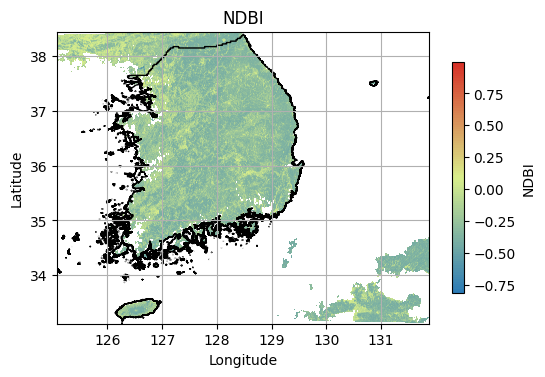

In [4]:
# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"
img_path = os.path.join(folder_path, "NDBI.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 사용자 정의 컬러맵 생성
colors = ["#2c7bb6", "#d9ef8b", "#d73027"]
cmap_name = 'custom_cmap'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap=cmap,
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('NDBI')

# 제목, 축 레이블, 그리드 설정
plt.title("NDBI")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()

In [ ]:
# NDVI 계산
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# NDVI layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["NDVI"],
    "min": -1,
    "max": 1,
    "palette": ['brown', 'yellow', 'green'],
}
Map.addLayer(ndvi, vis_params, "NDVI")
Map.add_colorbar(
    vis_params, label="NDVI", orientation="vertical", layer_name="ndvi"
)
Map.centerObject(kor.geometry(), 6)
Map

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
%%time

import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=ndvi,
    description='NDVI',
    folder='kari-sdm',
    scale=30,  # 이미지의 해상도
    region=kor.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(60)  # 60초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: READY
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: RUNNING
Polling for task (id: XR5RXYQLKFHNC7KA34RHYD45). Status: COMPLETED
Task completed. Final status:
{'state': 'COMPLETED', 'description': 'NDVI', 'priority': 100, 'creation_timestamp_ms': 1723625977099, 'update_timestamp_ms': 1723626610344, 'start_ti

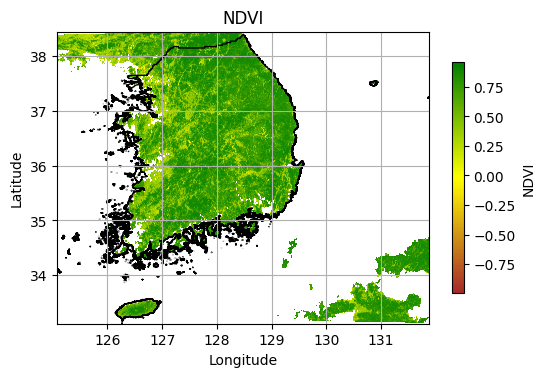

In [5]:
# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"
img_path = os.path.join(folder_path, "NDVI.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 사용자 정의 컬러맵 생성
colors = ['brown', 'yellow', 'green']
cmap_name = 'custom_cmap'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap=cmap,
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('NDVI')

# 제목, 축 레이블, 그리드 설정
plt.title("NDVI")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()

In [ ]:
# NDWI 계산
ndwi = s2_image.normalizedDifference(['B3', 'B8']).rename('NDWI')

# NDWI layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["NDWI"],
    "min": -1,
    "max": 1,
    "palette": ['#FFFFFF', '#00FFFF', '#0000FF'],
}
Map.addLayer(ndwi, vis_params, "NDWI")
Map.add_colorbar(
    vis_params, label="NDWI", orientation="vertical", layer_name="ndwi"
)
Map.centerObject(kor.geometry(), 6)
Map

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
%%time

import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=ndwi,
    description='NDWI',
    folder='kari-sdm',
    scale=30,  # 이미지의 해상도
    region=kor.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(60)  # 60초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: READY
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: RUNNING
Polling for task (id: SVCT35OGWAIFVSUARSXT3WVE). Status: COMPLETED
Task completed. Final status:
{'state': 'COMPLETED', 'description': 'NDWI', 'priority': 100, 'creation_timestamp_ms

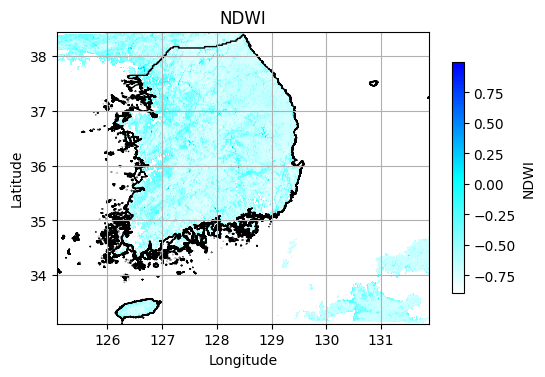

In [6]:
# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"
img_path = os.path.join(folder_path, "NDWI.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 사용자 정의 컬러맵 생성
colors = ['#FFFFFF', '#00FFFF', '#0000FF']
cmap_name = 'custom_cmap'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap=cmap,
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('NDWI')

# 제목, 축 레이블, 그리드 설정
plt.title("NDWI")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()